<h3> Imports

In [1]:
import torch
import torch.nn.functional as F 
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import nltk
import os
import random
from wordcloud import WordCloud

<h3>Loading News Data

In [2]:
data = pd.read_csv('datasets/news-article-categories.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6877 entries, 0 to 6876
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  6877 non-null   object
 1   title     6877 non-null   object
 2   body      6872 non-null   object
dtypes: object(3)
memory usage: 161.3+ KB


In [3]:
data.describe()

,category,title,body
count,6877,6877,6872
unique,14,6836,6815
top,ARTS & CULTURE,Extreme Weather Photos Of The Week,This week brought several big headlines in ext...
freq,1002,24,21


In [4]:
data.head()

,category,title,body
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,"In October 2017, Carolyn Kramer received a dis..."
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,This week I talked with actor Jeff Hiller abou...
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,The New Yorker is taking on President Donald T...
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,"Kellen Hickey, a 26-year-old who lives in Huds..."
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,There’s something about combining the traditio...


In [5]:
data_sans_na = data.dropna()

<h3>Exploring Categories

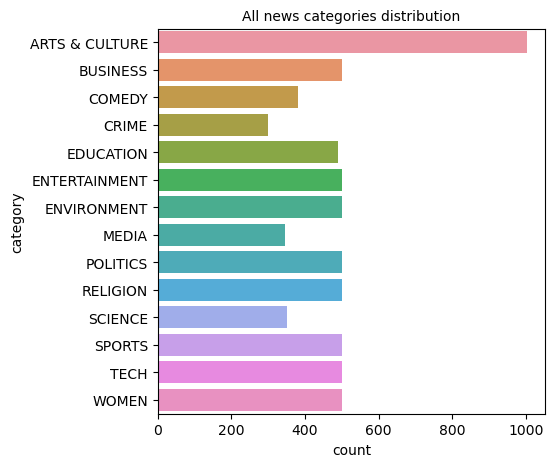

In [6]:
#Plot horizontal category distribution
plt.figure(figsize = [5, 5])
sns.countplot(y=data["category"], orient = 'h')
plt.title("All news categories distribution", fontsize = 10)
plt.show()

<h3> Word Cloud

In [7]:
dataset = pd.read_csv('datasets/news-article-categories-clean.csv')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6871 entries, 0 to 6870
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  6871 non-null   object
 1   title     6871 non-null   object
 2   body      6871 non-null   object
dtypes: object(3)
memory usage: 161.2+ KB


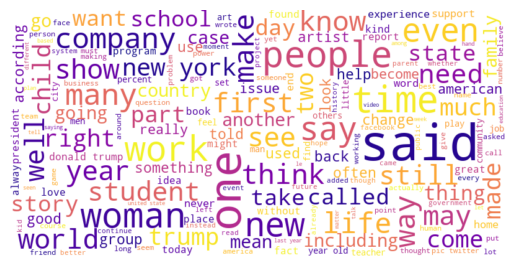

<Figure size 640x480 with 0 Axes>

In [30]:
# Word Cloud generator for the complete dataset and the 3 datasets

# Create a corpus of all words occuring in the reviews
corpus = " ".join(review for review in dataset.body)



# Function to create a word cloud object from the corpus with the color map as passed
def generateWordCloud(corpus: str, cmap: str) :#-> wordcloud:
    """
    Return a Word Cloud object generated from the corpus and color map parameter.
    """
    wordcloud = WordCloud(background_color = 'white', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

    wordcloud.generate(corpus)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

    return wordcloud
 
# Generate the Word Clouds for each of the Corpuses and save them as a PNG file
generateWordCloud(corpus = corpus, cmap = 'plasma').to_file('dataset_wc.png')

<h3>Max text length

In [10]:
print("Longest length is:\n",data.body.str.len().max())

Longest length is:
 72850.0


In [11]:
MAX_LEN = 72850

<h3> Train/Test split

In [12]:
X = data_sans_na.drop(["category"], axis =1)
X.head()

,title,body
0,Modeling Agencies Enabled Sexual Predators For...,"In October 2017, Carolyn Kramer received a dis..."
1,Actor Jeff Hiller Talks “Bright Colors And Bol...,This week I talked with actor Jeff Hiller abou...
2,New Yorker Cover Puts Trump 'In The Hole' Afte...,The New Yorker is taking on President Donald T...
3,Man Surprises Girlfriend By Drawing Them In Di...,"Kellen Hickey, a 26-year-old who lives in Huds..."
4,This Artist Gives Renaissance-Style Sculptures...,There’s something about combining the traditio...


In [13]:
y = data_sans_na["category"]
y.head()

0    ARTS & CULTURE
1    ARTS & CULTURE
2    ARTS & CULTURE
3    ARTS & CULTURE
4    ARTS & CULTURE
Name: category, dtype: object

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [15]:
y_train

3448      ENVIRONMENT
6279             TECH
2738    ENTERTAINMENT
6678            WOMEN
3374      ENVIRONMENT
            ...      
3719            MEDIA
3330      ENVIRONMENT
1415         BUSINESS
5792           SPORTS
5968             TECH
Name: category, Length: 5497, dtype: object

In [16]:
train_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)

In [17]:
train_dataset.head()

,title,body,category
3448,"In First Vote, Columbia College Students Back ...",73.7 percent of voting Columbia College studen...,ENVIRONMENT
6279,Facebook Is Developing A Camera App To Rival S...,(Reuters) - Facebook Inc is developing a stand...,TECH
2738,The Obamas Are Coming To Your Netflix Queue,Former President Barack Obama and first lady M...,ENTERTAINMENT
6678,When Sexual Harassment Extends From The Workpl...,After being inundated with the stories of the ...,WOMEN
3374,"Kitten Meets Bearded Dragon, Freaks Out Ninja-...",Bearded dragons were only introduced to the Un...,ENVIRONMENT


<h3> Genenal Settings

In [18]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 15

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 14

<h3> Tokenizer

In [19]:
tokenizer = get_tokenizer("basic_english")

In [20]:
test = tokenizer("This is a test, how are you Marcelino")

In [21]:
test

['this', 'is', 'a', 'test', ',', 'how', 'are', 'you', 'marcelino']

In [22]:
def build_vocabulary(datasets):
    for dataset in datasets:
        for _, title, body, category in dataset:
            print(body)
            #yield tokenizer(body)

In [23]:
# Define a function that takes in a sentence and returns the tokenized version
def tokenize_sentence(sentence):
  tokens = tokenizer(sentence)
  return tokens

In [24]:
train_dataset.head()

,title,body,category
3448,"In First Vote, Columbia College Students Back ...",73.7 percent of voting Columbia College studen...,ENVIRONMENT
6279,Facebook Is Developing A Camera App To Rival S...,(Reuters) - Facebook Inc is developing a stand...,TECH
2738,The Obamas Are Coming To Your Netflix Queue,Former President Barack Obama and first lady M...,ENTERTAINMENT
6678,When Sexual Harassment Extends From The Workpl...,After being inundated with the stories of the ...,WOMEN
3374,"Kitten Meets Bearded Dragon, Freaks Out Ninja-...",Bearded dragons were only introduced to the Un...,ENVIRONMENT


In [25]:
# Apply the function to each row in the dataframe
train_dataset['token'] = train_dataset['body'].apply(tokenize_sentence)
test_dataset['token'] = test_dataset['body'].apply(tokenize_sentence)

In [26]:
token_list = pd.concat([train_dataset['token'],test_dataset['token']])

In [27]:
vocab = build_vocab_from_iterator(token_list, min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

In [28]:
len(vocab)


114811

In [29]:
indexes = vocab(test)

test, indexes
#Last word Marcelino unknown so token is 0

(['this', 'is', 'a', 'test', ',', 'how', 'are', 'you', 'marcelino'],
 [22, 10, 7, 831, 1, 78, 19, 25, 0])